In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn")
import seaborn as sns
import re
import os
from tqdm import tqdm
import math
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
import xml.etree.ElementTree as etree
import time
from wordcloud import WordCloud

import json
with open('Data/stop_words_english.json') as json_file:
    stops = json.load(json_file)

In [2]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', 50)
pd.set_option('display.min_rows', 50)

## Fonctions

In [5]:
def post_to_words( post_text, stopwords_lem=True):
    # 1. Retire les caractères spéciaux et certains paternes non souhaités
    post_text = re.sub(r"(\\n)|(\.\\n)|(\'\w+)|(http*\S+)|[^\w\s\.,#+-]", " ", post_text)
    post_text = re.sub(r"(\.\s)|(\.$)|(,\s)|(\s#\s)|(\'\w+)|(\s\-\s)", " ", post_text)
    post_text = re.sub(r"(\s-?\+?\d{0,4}\s)", " ", post_text)
    post_text = re.sub(r"\s+", " ", post_text)
    # 2. passe tout en minuscule, et découpe les mots
    words = post_text.lower().split()
    if stopwords_lem :
        # 3. Retire les Stop Words
        words = [w for w in words if not w in stops]
        # 4. Garde le radical des mots
        lemmatizer = WordNetLemmatizer()
        words = [lemmatizer.lemmatize(w) for w in words]
    return " ".join( words )

In [6]:
def clean_html_body(text):
    # récupère le texte brut de l'HTML
    soup = BeautifulSoup(text)
    code_to_remove = soup.findAll("code")
    for code in code_to_remove:
        code.replace_with(" ")
    return soup.get_text()

In [7]:
def clean_tags(x):
    # conserve que les tags souhaités
    tag_iter = []
    for tag in x:
        if tag in Tags_name_list:
            tag_iter.append(tag)
    return tag_iter

In [8]:
def split_tags(x):
    # passe les tags d'une chaine de caractère à une liste
    return re.sub(r"><", " ", re.sub(r"^<|>$", "", x)).split()

## de l'XML au CSV
premier découpage du fichier XML

In [ ]:
outro = "</posts>"
it = 0
valid = 0
count = 1
start_time = time.time()
with open('Data/Posts.xml', 'r', encoding='utf8') as inputFile :
    outputLine = []
    intro = []
    intro.append(inputFile.readline())
    intro.append(inputFile.readline())
    outputLine.extend(intro)
    for inputLine in inputFile :
        if 'PostTypeId="1"' in inputLine :
            outputLine.append(inputLine)
            valid += 1
            if valid % 100000 == 0 :
                interval = time.time() - start_time
                print("{:,} lignes de gardées sur {:,}. ça avance    ".format(valid, it) + '{h}:%.3f temps passé'.format(h = int(interval//60)) % (interval%60))
            if valid % 1000000 == 0 :
                outputLine.append(outro)
                interval = time.time() - start_time
                with open('Data/PostsXML_lite' + str(count) + '.xml', 'w', encoding='utf8') as outputFile :
                    outputFile.writelines(outputLine)
                print("{:,} lignes de gardées sur {:,} : les données sont conservées sur Data/PostsXML_lite".format(valid, it)+ str(count) +".xml")
                count += 1
                outputLine = []
                outputLine.extend(intro)
        it += 1
    outputLine.append(outro)
    interval = time.time() - start_time
    with open('Data/PostsXML_lite' + str(count) + '.xml', 'w', encoding='utf8') as outputFile :
        outputFile.writelines(outputLine)
    print("{:,} lignes de gardées sur {:,} : les données sont conservées sur Data/PostsXML_lite".format(valid, it)+ str(count) +".xml")

passage des fichiers XML au CSV

In [ ]:
row = 0
count = 23
start_time = time.time()
for it in range(1, count) :
    postXML = []
    for event, elem in etree.iterparse("Data/PostsXML_lite" + str(it) + ".xml"):
        if elem.tag == 'row' :
            row += 1
            postXML.append(elem.attrib)
            if row % 100000 == 0 :
                interval = time.time() - start_time
                print("{:,} lignes traitées. ça avance    ".format(row) + '{h}:%.3f temps passé'.format(h = int(interval//60)) % (interval%60))
    pd.DataFrame(postXML).to_csv("Data/PostsXML_"+ str(it) +".csv")
    print("{:,} lignes de traitées : les données sont conservées sur Data/PostsXML_".format(row)+ str(it) +".csv")
    os.remove("Data/PostsXML_lite" + str(it) + ".xml")

## Nettoyage

In [42]:
# Chargement d'un fichier csv
postXML = pd.read_csv('Data/PostsXML_20.csv', index_col=0)
postXML['Tags_list'] = postXML['Tags'].apply(split_tags)
# Récupération des tags
tags_binarizer = MultiLabelBinarizer(sparse_output=True)
Tags = tags_binarizer.fit_transform(postXML.Tags_list)
Tags_list = pd.DataFrame(data={"Nom":tags_binarizer.classes_.tolist(), "Nombre": Tags.sum(axis=0).tolist()[0]}).sort_values(by="Nombre", ascending=False, ignore_index=True)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3098: DtypeWarning: Columns (21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


### Analyse exploratoire

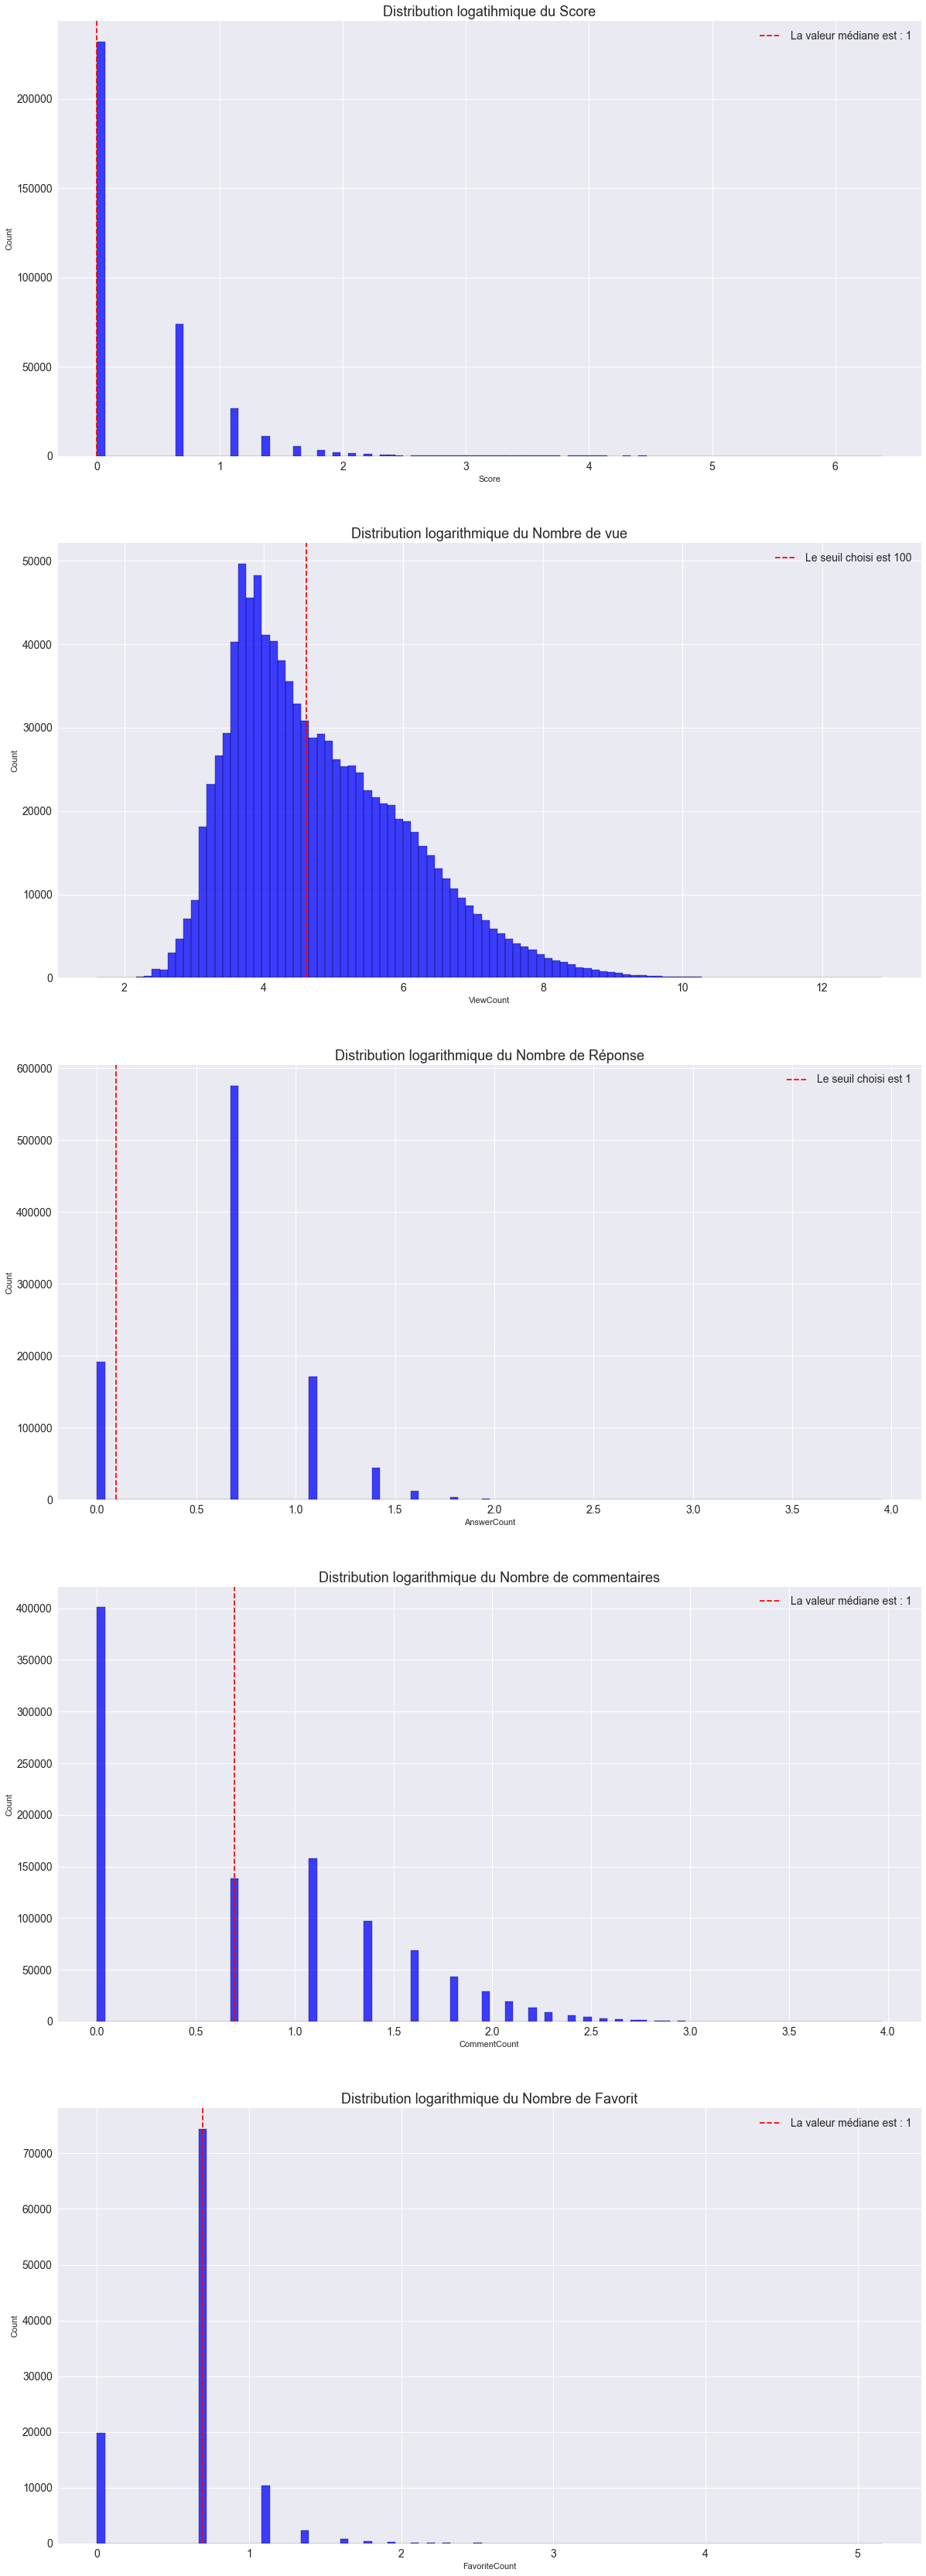

In [29]:
fig = plt.figure(figsize=(20, 12*5))

plt.subplot(511)
sns.histplot(np.log(postXML[postXML['Score'] > 0]['Score']), bins=100, color="blue")
plt.title("Distribution logarithmique du Score", fontsize=18)
plt.axvline(np.log(postXML[postXML['Score'] > 0]['Score']).median(), color="r", linestyle='--',
            label="La valeur médiane est : {:.0f}".format(postXML[postXML['Score'] > 0]['Score'].median()))
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(512)
sns.histplot(np.log(postXML['ViewCount'] + 1), bins=100, color="blue")
plt.title("Distribution logarithmique du Nombre de vue", fontsize=18)
plt.axvline(math.log(100), color="r", linestyle='--', label="Le seuil choisi est 100")
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(513)
sns.histplot(np.log(postXML['AnswerCount'] + 1), bins=100, color="blue")
plt.title("Distribution logarithmique du Nombre de Réponse", fontsize=18)
plt.axvline(math.log(1.1), color="r", linestyle='--', label="Le seuil choisi est 1")
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(514)
sns.histplot(np.log(postXML['CommentCount'] + 1), bins=100, color="blue")
plt.title("Distribution logarithmique du Nombre de commentaires", fontsize=18)
plt.axvline(np.log(postXML['CommentCount'] + 1).median(), color="r", linestyle='--',
            label="La valeur médiane est : {:.0f}".format(postXML['CommentCount'].median()))
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(515)
sns.histplot(np.log(postXML['FavoriteCount'] + 1), bins=100, color="blue")
plt.title("Distribution logarithmique du Nombre de Favorit", fontsize=18)
plt.axvline(np.log(postXML['FavoriteCount'] + 1).median(), color="r", linestyle='--',
            label="La valeur médiane est : {:.0f}".format(postXML['FavoriteCount'].median()))
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()


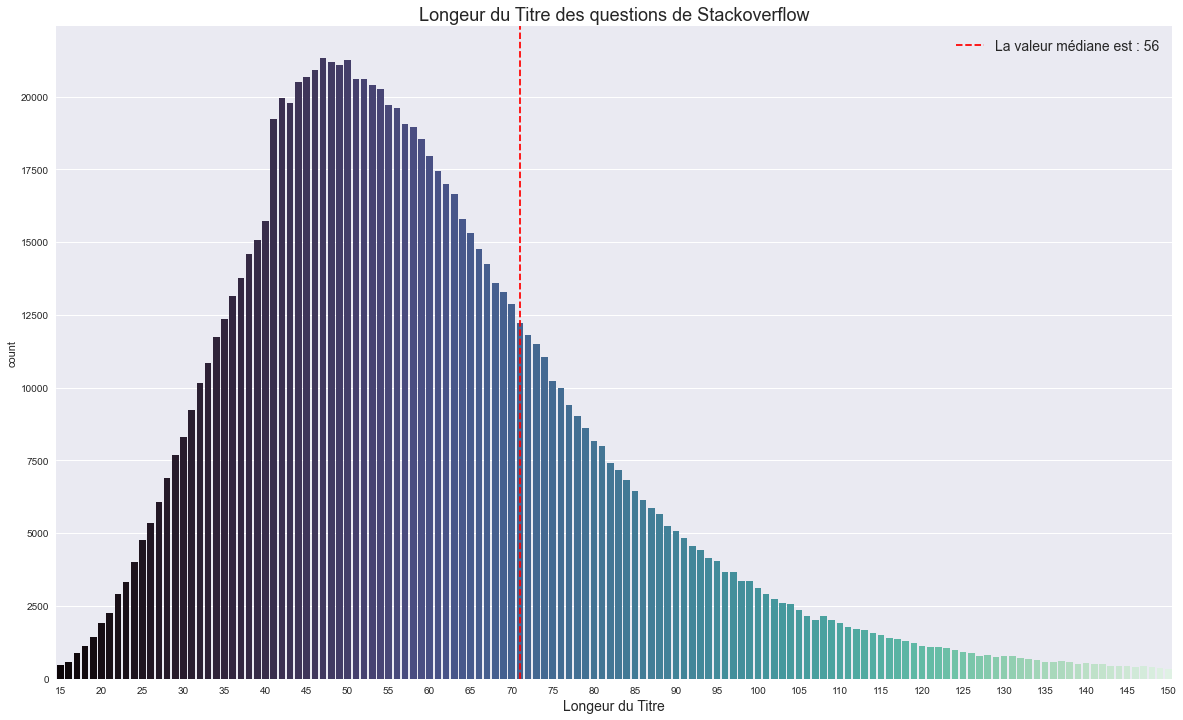

In [31]:
fig = plt.figure(figsize=(20, 12))
ax = sns.countplot(x=postXML.Title.str.len(), palette="mako")
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(0, end, 5))
plt.axvline(postXML.Title.str.len().median(),
            color="r", linestyle='--',
            label="La valeur médiane est : {:.0f}".format(postXML.Title.str.len().median()))
ax.set_xlabel("Longeur du Titre", fontsize=14)
plt.title("Longeur du Titre des questions de Stackoverflow",
          fontsize=18)
plt.legend(fontsize=14)
plt.show()


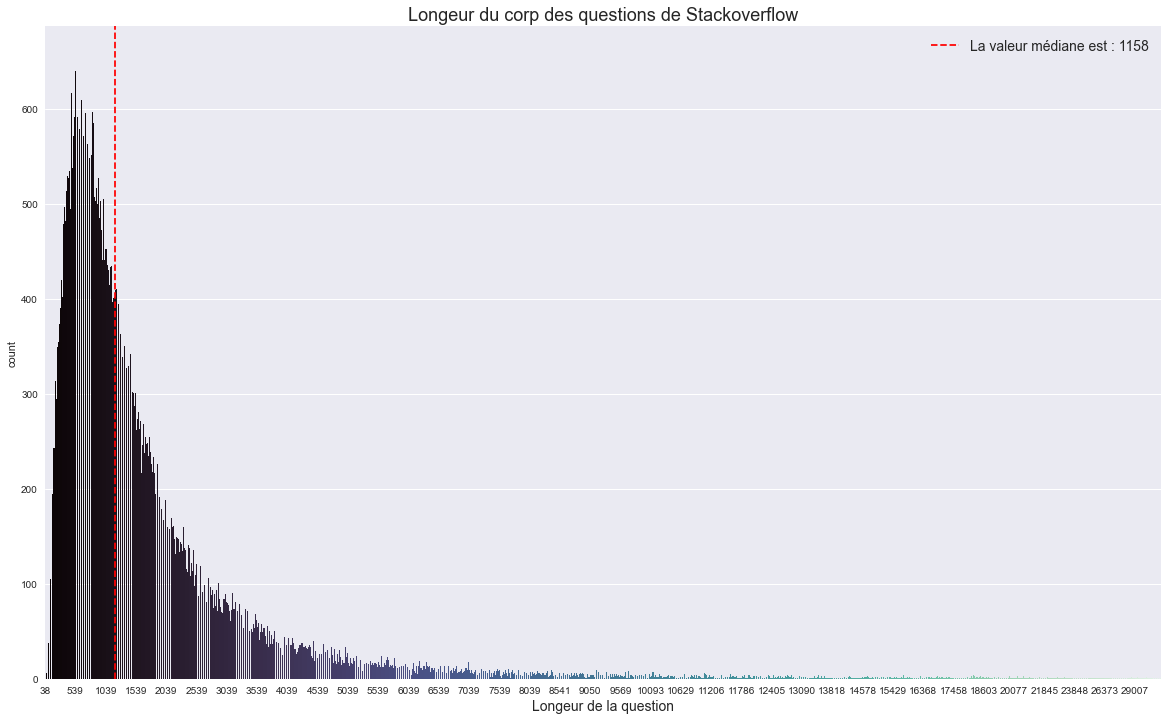

In [32]:
fig = plt.figure(figsize=(20, 12))
ax = sns.countplot(x=postXML.Body.str.len(), palette="mako")
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(0, end, 500))
plt.axvline(postXML.Body.str.len().median(),
            color="r", linestyle='--',
            label="La valeur médiane est : {:.0f}".format(postXML.Body.str.len().median()))
ax.set_xlabel("Longeur de la question", fontsize=14)
plt.title("Longeur du corps des questions de Stackoverflow", fontsize=18)
plt.legend(fontsize=14)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


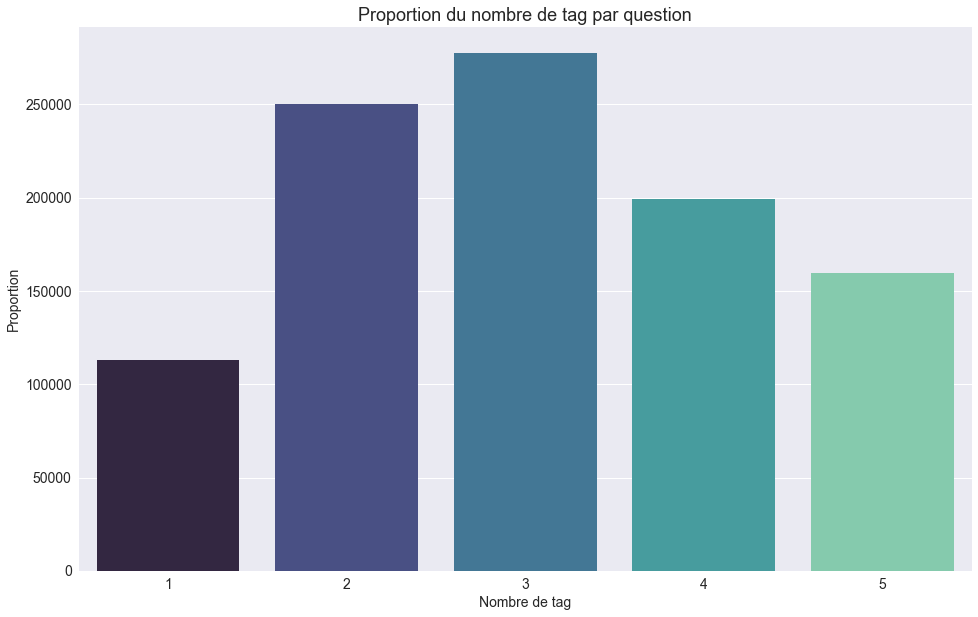

In [33]:
fig = plt.figure(figsize=(16, 10))
sns.countplot(postXML['Tags_list'].str.len(), palette="mako")
plt.title("Proportion du nombre de tag par question", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Nombre de tag", fontsize=14)
plt.ylabel("Proportion", fontsize=14)
plt.show()

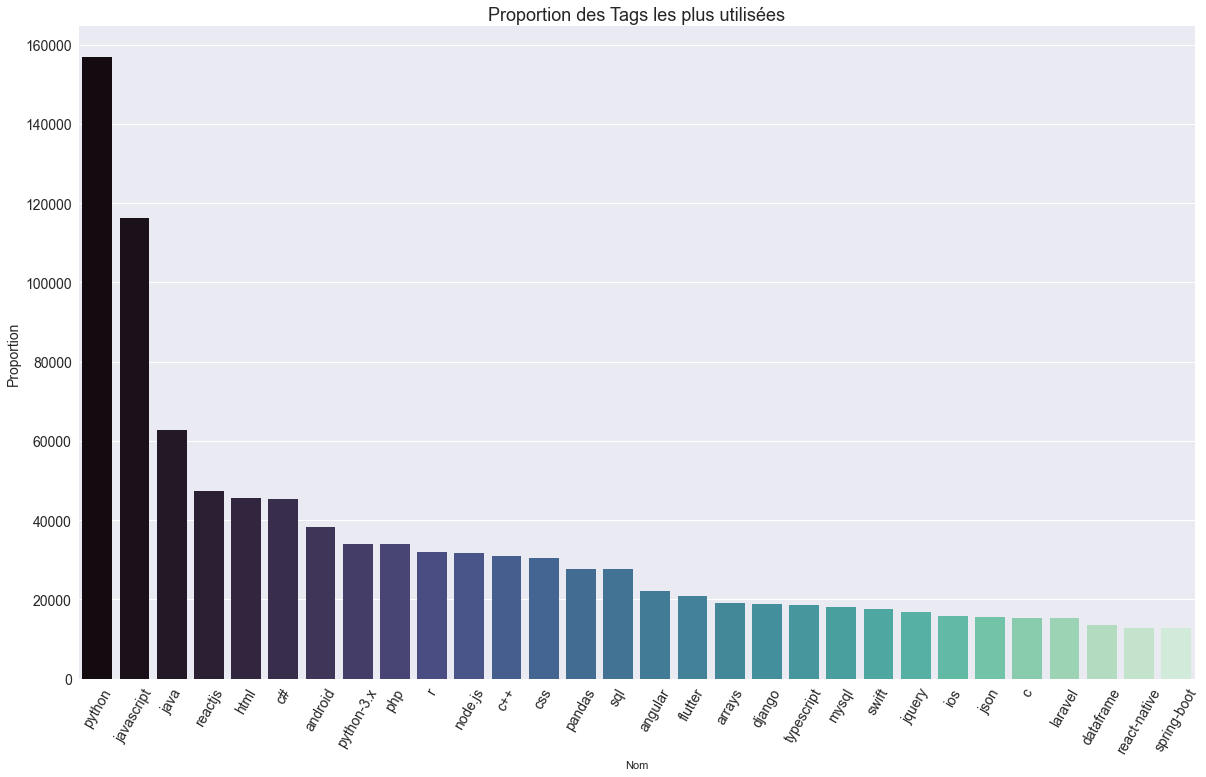

In [34]:
fig = plt.figure(figsize=(20, 12))
sns.barplot(x=Tags_list[:30]['Nom'], y=Tags_list[:30]['Nombre'], palette="mako")
plt.title("Proportion des Tags les plus utilisés", fontsize=18)
plt.ylabel("Proportion", fontsize=14)
plt.xticks(fontsize=14, rotation=60)
plt.yticks(fontsize=14)
plt.show()


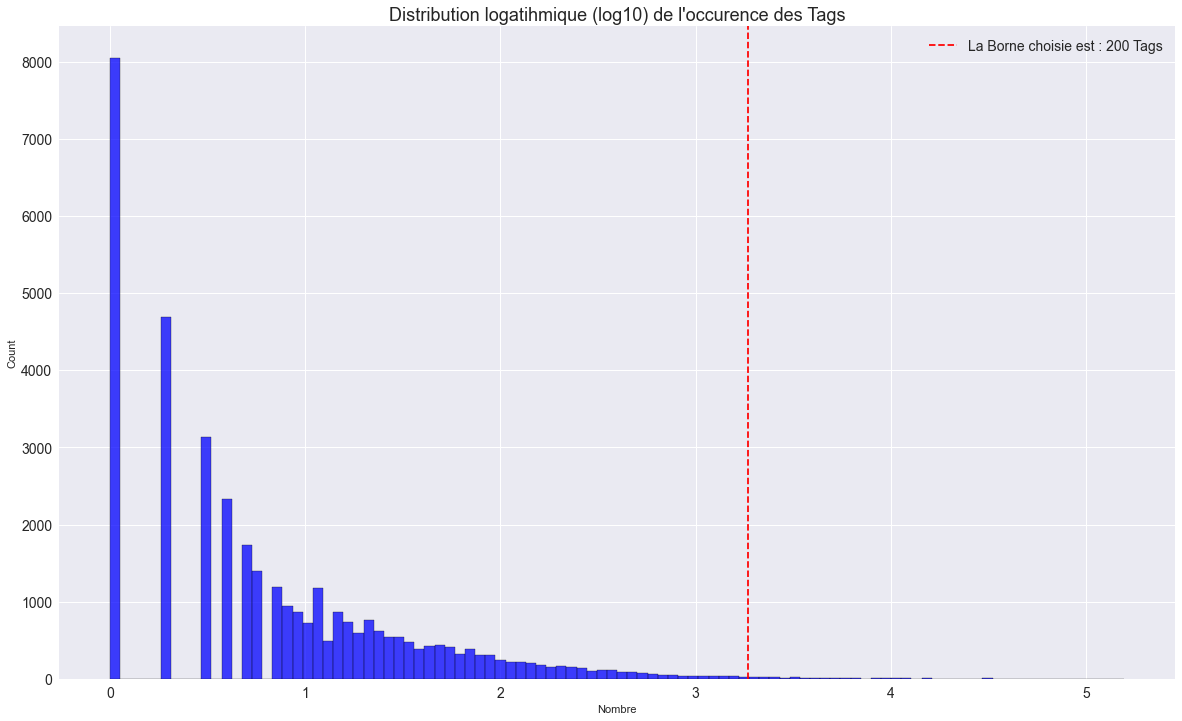

In [49]:
fig = plt.figure(figsize=(20, 12))
sns.histplot(np.log10(Tags_list['Nombre']), bins=100, color="blue")
plt.title("Distribution logarithmique (log10) de l'occurrence des Tags",
          fontsize=18)
plt.axvline(np.log10(Tags_list[:200]['Nombre'].min()),
            color="r", linestyle='--',
            label="La Borne choisie est : 200 Tags")
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

### Filtrage des tags

In [37]:
shape_avant = Tags_list.shape[0]
Tags_list = Tags_list[:200]
Tags_name_list = Tags_list['Nom'].to_list()
print('le nombre de Tags unique est passé de {} à {} soit on a perdue {:.2f}%'.format(shape_avant, Tags_list.shape[0], (1-Tags_list.shape[0]/shape_avant)*100))

le nombre de Tags unique est passé de 37758 à 200 soit on à perdue 99.47%


### Filtrage des questions

In [38]:
shape_avant = postXML.shape[0]
postXML = postXML[postXML['AnswerCount'] >= 1]
postXML = postXML[postXML['ViewCount'] >= 100]
postXML['Tags_list'] = postXML['Tags_list'].apply(clean_tags).str.join(' ')
postXML = postXML[postXML['Tags_list'] != '']
print('le nombre de question est passé de {} à {} soit on a perdue {:.2f}%'.format(shape_avant, postXML.shape[0], (1-postXML.shape[0]/shape_avant)*100))

le nombre de question est passé de 1000000 à 367079 soit on à perdue 63.29%


### Nettoyage des questions

In [39]:
postXML['Body_clean'] = postXML['Body'].apply(clean_html_body)
postXML['Text'] = (postXML['Body_clean'] + " " + postXML['Title']).apply(post_to_words)
postXML['Text_len'] = postXML['Text'].str.split().str.len()
borne_text = (postXML['Text_len'].quantile(0.75) - postXML['Text_len'].quantile(0.25))*2 + postXML['Text_len'].quantile(0.75)

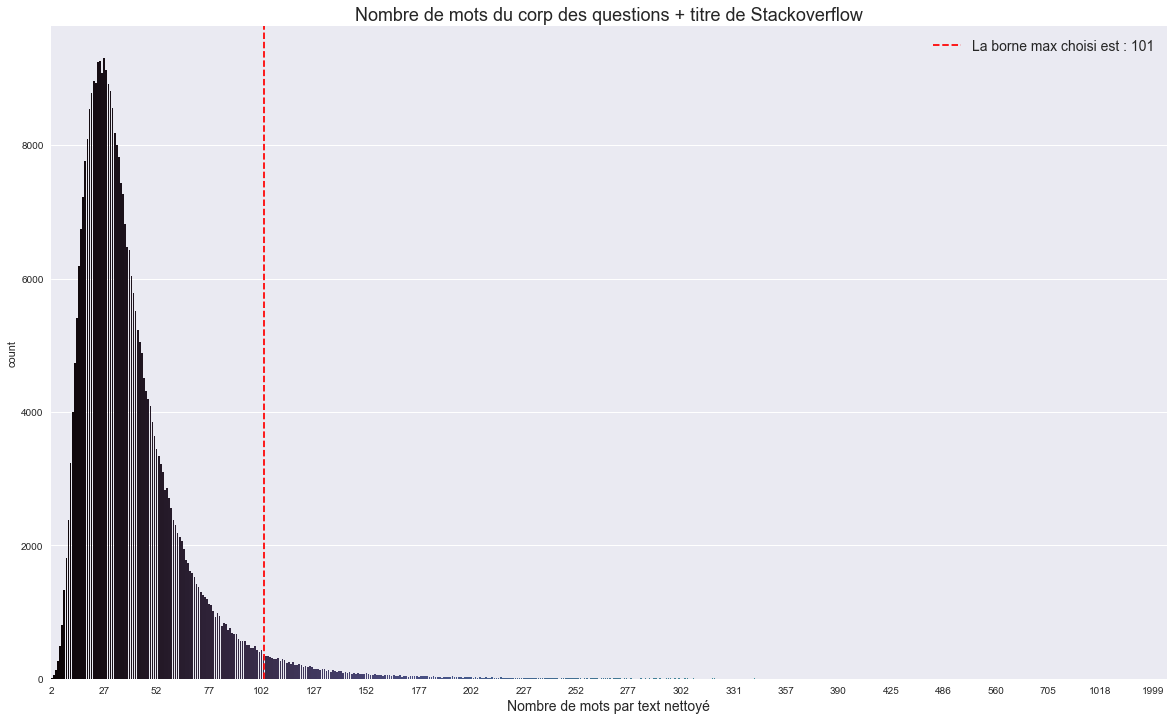

In [40]:
fig = plt.figure(figsize=(20, 12))
ax = sns.countplot(x=postXML['Text_len'], palette="mako")
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(0, end, 25))
plt.axvline(borne_text,
            color="r", linestyle='--',
            label="La borne max choisie est : {:.0f}".format(borne_text))
ax.set_xlabel("Nombre de mots par texte nettoyé", fontsize=14)
plt.title("Nombre de mots du corps des questions + titre de Stackoverflow", fontsize=18)
plt.legend(fontsize=14)
plt.show()

In [41]:
postXML = postXML[postXML['Text_len'] < borne_text]
print('le nombre de question est passé de {} à {} soit on a perdue {:.2f}%'.format(shape_avant, postXML.shape[0], (1-postXML.shape[0]/shape_avant)*100))

le nombre de question est passé de 1000000 à 354121 soit on à perdue 64.59%


### Export

In [28]:
postXML[["Text", "Tags_list"]].to_csv("Data/Posts_Clean_1.csv")

## Nettoyage a la chaine

les mêmes étapes que vue dans la partie précédente appliquées à tous les fichiers

In [8]:
postMin = 14
postMax = 22
start_time = time.time()
for it in range(postMin, postMax+1):
    postXML = pd.read_csv('Data/PostsXML_'+str(it)+'.csv', index_col=0)
    postXML['Tags_list'] = postXML['Tags'].apply(split_tags)
    tags_binarizer = MultiLabelBinarizer(sparse_output=True)
    Tags = tags_binarizer.fit_transform(postXML.Tags_list)
    Tags_list = pd.DataFrame(data={"Nom":tags_binarizer.classes_.tolist(), "Nombre": Tags.sum(axis=0).tolist()[0]}).sort_values(by="Nombre", ascending=False, ignore_index=True)
    shape_tags = Tags_list.shape[0]
    Tags_list = Tags_list[Tags_list['Nombre'] >= 100]
    Tags_name_list = Tags_list['Nom'].to_list()
    shape_avant = postXML.shape[0]
    postXML = postXML[postXML['AnswerCount'] >= 1]
    postXML = postXML[postXML['ViewCount'] >= 100]
    postXML['Tags_list'] = postXML['Tags_list'].apply(clean_tags).str.join(' ')
    postXML = postXML[postXML['Tags_list'] != '']
    postXML['Body_clean'] = postXML['Body'].apply(clean_html_body)
    postXML['Text'] = (postXML['Body_clean'] + " " + postXML['Title']).apply(post_to_words)
    interval = time.time() - start_time
    print('Traitement du text effectué    {h}:%.3f temps passé'.format(h = int(interval//60)) % (interval%60))
    postXML['Text_len'] = postXML['Text'].str.split().str.len()
    borne_text = (postXML['Text_len'].quantile(0.75) - postXML['Text_len'].quantile(0.25))*2 + postXML['Text_len'].quantile(0.75)
    postXML = postXML[postXML['Text_len'] < borne_text]
    print('Tags unique: de {} à {} soit {:.2f}% en moins  '.format(shape_tags, Tags_list.shape[0], (1-Tags_list.shape[0]/shape_tags)*100) + \
          'question: de {} à {} soit {:.2f}% en moins'.format(shape_avant, postXML.shape[0], (1-postXML.shape[0]/shape_avant)*100))
    postXML[["Text", "Tags_list"]].to_csv('Data/Posts_Clean_'+str(it)+'.csv')
    interval = time.time() - start_time
    print('le post {} est enregistré      {h}:%.3f temps passé'.format(it, h = int(interval//60)) % (interval%60))

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3098: DtypeWarning: Columns (21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Traitement du text effectué    16:37.634 temps passé
Tags unique: de 35335 à 2787 soit 92.11% en moinsquestion: de 1000000 à 601846 soit 39.82% en moins
le post 14 est enregistré      16:48.923 temps passé


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3098: DtypeWarning: Columns (21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Traitement du text effectué    33:16.943 temps passé
Tags unique: de 36106 à 2771 soit 92.33% en moinsquestion: de 1000000 à 580579 soit 41.94% en moins
le post 15 est enregistré      33:27.167 temps passé


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3098: DtypeWarning: Columns (21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Traitement du text effectué    49:25.502 temps passé
Tags unique: de 36569 à 2817 soit 92.30% en moinsquestion: de 1000000 à 556467 soit 44.35% en moins
le post 16 est enregistré      49:36.699 temps passé
Traitement du text effectué    65:20.596 temps passé
Tags unique: de 36534 à 2776 soit 92.40% en moinsquestion: de 1000000 à 531438 soit 46.86% en moins
le post 17 est enregistré      65:30.785 temps passé


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3098: DtypeWarning: Columns (21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Traitement du text effectué    80:33.910 temps passé
Tags unique: de 36514 à 2715 soit 92.56% en moinsquestion: de 1000000 à 495852 soit 50.41% en moins
le post 18 est enregistré      80:44.715 temps passé
Traitement du text effectué    94:27.064 temps passé
Tags unique: de 37410 à 2795 soit 92.53% en moinsquestion: de 1000000 à 448518 soit 55.15% en moins
le post 19 est enregistré      94:35.920 temps passé


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3098: DtypeWarning: Columns (21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Traitement du text effectué    106:47.766 temps passé
Tags unique: de 37758 à 2774 soit 92.65% en moinsquestion: de 1000000 à 392055 soit 60.79% en moins
le post 20 est enregistré      106:55.074 temps passé


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3098: DtypeWarning: Columns (21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Traitement du text effectué    114:44.262 temps passé
Tags unique: de 39184 à 2881 soit 92.65% en moinsquestion: de 1000000 à 235480 soit 76.45% en moins
le post 21 est enregistré      114:48.599 temps passé
Traitement du text effectué    118:26.298 temps passé
Tags unique: de 39906 à 2830 soit 92.91% en moinsquestion: de 978327 à 89782 soit 90.82% en moins
le post 22 est enregistré      118:28.347 temps passé


## Regroupement des Fichiers

In [3]:
count = 23
posts = pd.DataFrame(columns=['Text', 'Tags_list'])
for it in range(1, count):
    posts_clean = pd.read_csv('Data/Posts_Clean_{}.csv'.format(it), index_col=0)
    posts = posts.append(posts_clean, ignore_index=True)
    print('fichier N°{} ajouté'.format(it))

fichier N°1 ajouté
fichier N°2 ajouté
fichier N°3 ajouté
fichier N°4 ajouté
fichier N°5 ajouté
fichier N°6 ajouté
fichier N°7 ajouté
fichier N°8 ajouté
fichier N°9 ajouté
fichier N°10 ajouté
fichier N°11 ajouté
fichier N°12 ajouté
fichier N°13 ajouté
fichier N°14 ajouté
fichier N°15 ajouté
fichier N°16 ajouté
fichier N°17 ajouté
fichier N°18 ajouté
fichier N°19 ajouté
fichier N°20 ajouté
fichier N°21 ajouté
fichier N°22 ajouté


In [4]:
posts = posts.astype({'Text': 'string', 'Tags_list': 'string'})
drop_list = []
for i, elem in enumerate(posts.Text):
    if type(elem) != str:
        drop_list.append(i)
for i, elem in enumerate(posts.Tags_list):
    if type(elem) != str:
        drop_list.append(i)
print('il y a {} questions sans tags ou question'.format(len(drop_list)))
posts.drop(drop_list, inplace=True)
posts['Tags_list'] = posts['Tags_list'].str.split()
tags_binarizer = MultiLabelBinarizer(sparse_output=True)
Tags = tags_binarizer.fit_transform(posts.Tags_list)
Tags_list = pd.DataFrame(data={"Nom":tags_binarizer.classes_.tolist(), "Nombre": Tags.sum(axis=0).tolist()[0]}).sort_values(by="Nombre", ascending=False, ignore_index=True)
borne_tag = Tags_list[:200]['Nombre'].min()

il y a 85 questions sans tags ou question


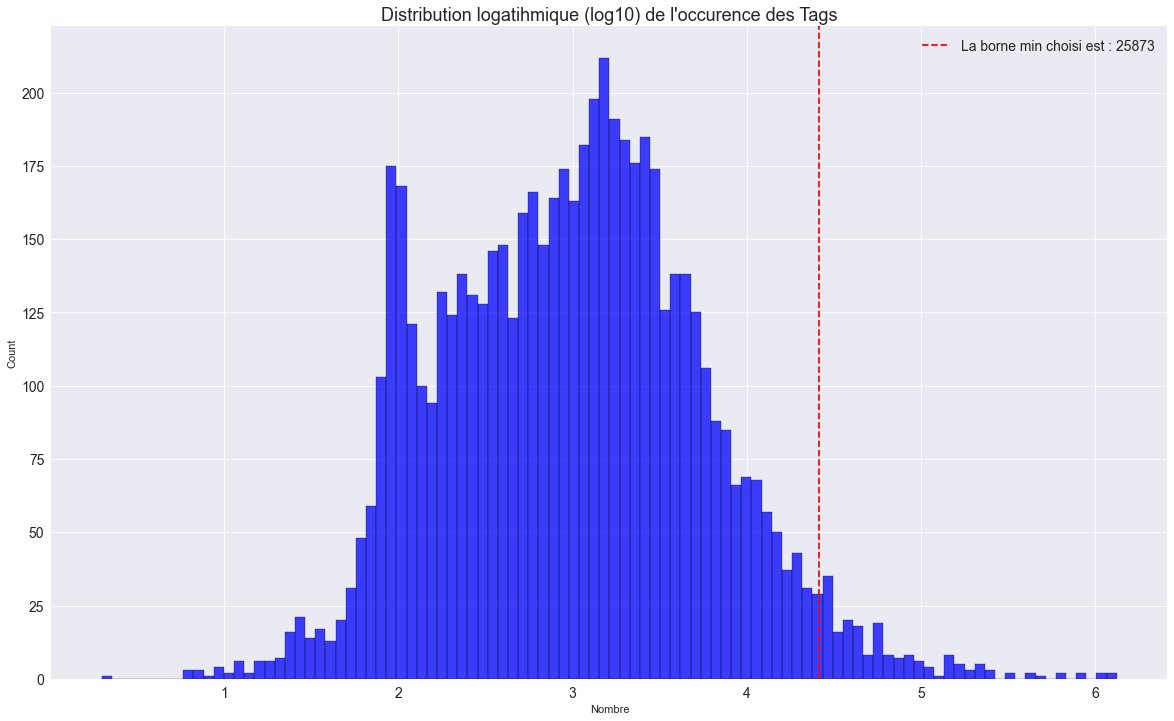

In [11]:
fig = plt.figure(figsize=(20, 12))
sns.histplot(np.log10(Tags_list['Nombre']), bins=100, color="blue")
plt.title("Distribution logarithmique (log10) de l'occurrence des Tags",
          fontsize=18)
plt.axvline(np.log10(borne_tag),
            color="r", linestyle='--',
            label="La borne min choisie est : {:.0f}".format(borne_tag))
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

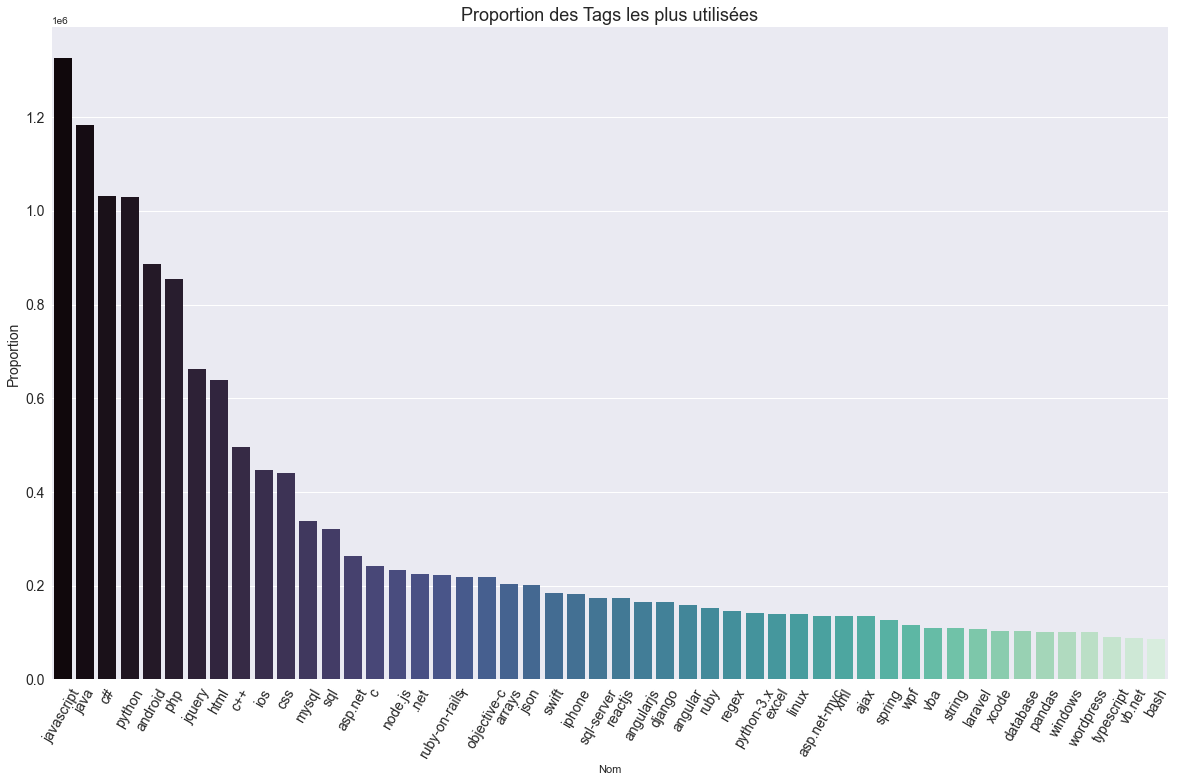

In [12]:
fig = plt.figure(figsize=(20, 12))
sns.barplot(x=Tags_list[:50]['Nom'], y=Tags_list[:50]['Nombre'], palette="mako")
plt.title("Proportion des Tags les plus utilisées", fontsize=18)
plt.ylabel("Proportion", fontsize=14)
plt.xticks(fontsize=14, rotation=60)
plt.yticks(fontsize=14)
plt.show()

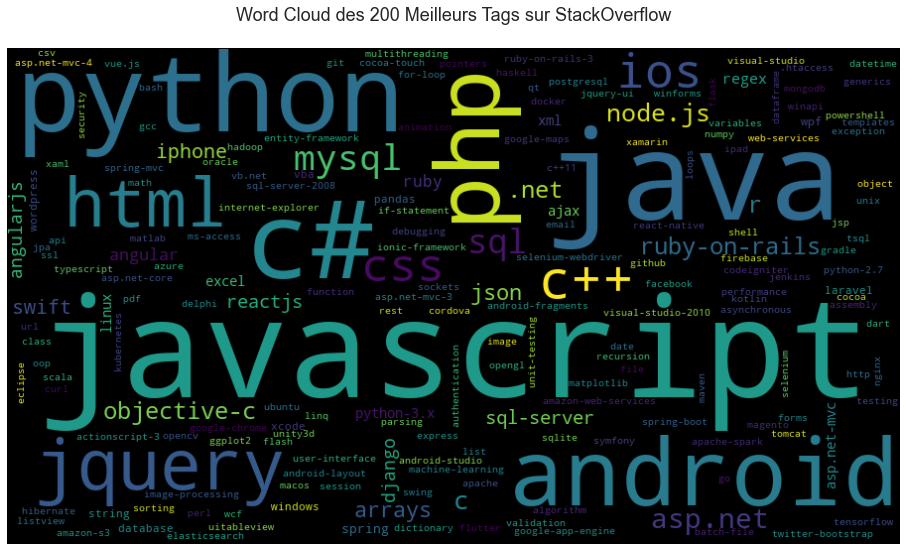

In [6]:
fig = plt.figure(1, figsize=(16, 12))
ax = fig.add_subplot(1, 1, 1)
wordcloud = WordCloud(width=900, height=500,
                      background_color="black",
                      max_words=200, relative_scaling=1,
                      normalize_plurals=False)\
    .generate_from_frequencies(Tags_list.set_index('Nom').to_dict()['Nombre'])

ax.imshow(wordcloud, interpolation='bilinear')
ax.axis("off")
plt.title("Word Cloud des 200 Meilleurs Tags sur StackOverflow\n",
          fontsize=18)
plt.show()

### Dernier Filtrage des tags

In [15]:
shape_tags = Tags_list.shape[0]
Tags_list = Tags_list[Tags_list['Nombre'] >= borne_tag]
Tags_name_list = Tags_list['Nom'].to_list()
shape_avant = posts.shape[0]
posts['Tags_list'] = posts['Tags_list'].apply(clean_tags).str.join(' ')
posts = posts[posts['Tags_list'] != '']
print('Tags unique: de {} à {} soit {:.2f}% en moins - '.format(shape_tags, Tags_list.shape[0], (1-Tags_list.shape[0]/shape_tags)*100) + \
      'question: de {} à {} soit {:.2f}% en moins'.format(shape_avant, posts.shape[0], (1-posts.shape[0]/shape_avant)*100))

Tags unique: de 6030 à 200 soit 96.68% en moins - question: de 13456195 à 12018607 soit 10.68% en moins


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


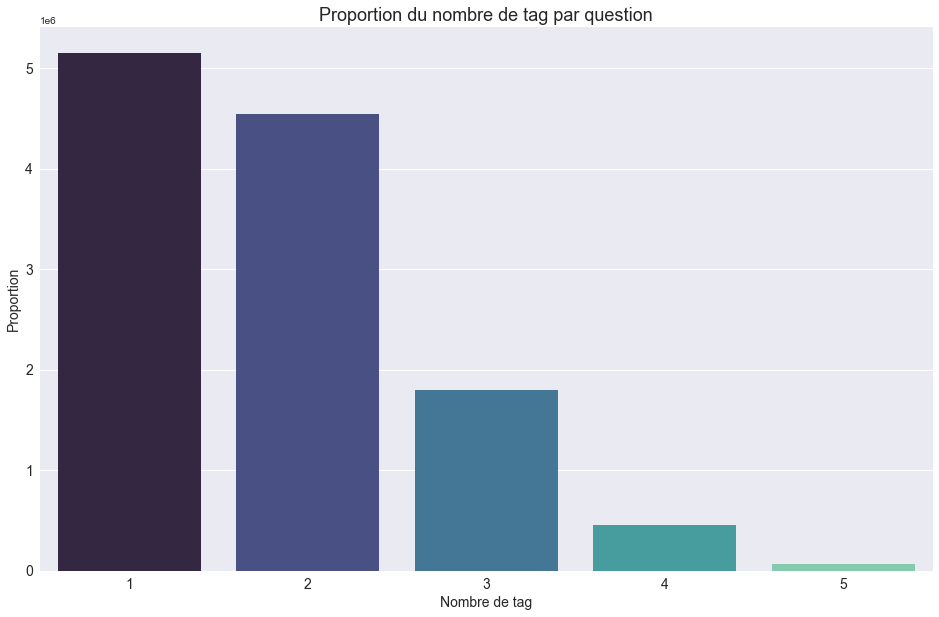

In [22]:
fig = plt.figure(figsize=(16, 10))
sns.countplot(posts['Tags_list'].str.split().str.len(), palette="mako")
plt.title("Proportion du nombre de tag par question", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Nombre de tag", fontsize=14)
plt.ylabel("Proportion", fontsize=14)
plt.show()

### Visualisation des mots

In [24]:
count_vect = CountVectorizer(lowercase=False, token_pattern=r"\S+", max_features=2000)
bag_of_word = count_vect.fit_transform(posts['Text'])
word_sum = pd.DataFrame(bag_of_word.sum(axis=0).T, index=count_vect.get_feature_names_out(), columns=['freq']).sort_values(by='freq', ascending=False)['freq']
del bag_of_word
word_sum_log: pd.DataFrame  = pd.DataFrame(np.log10(word_sum))

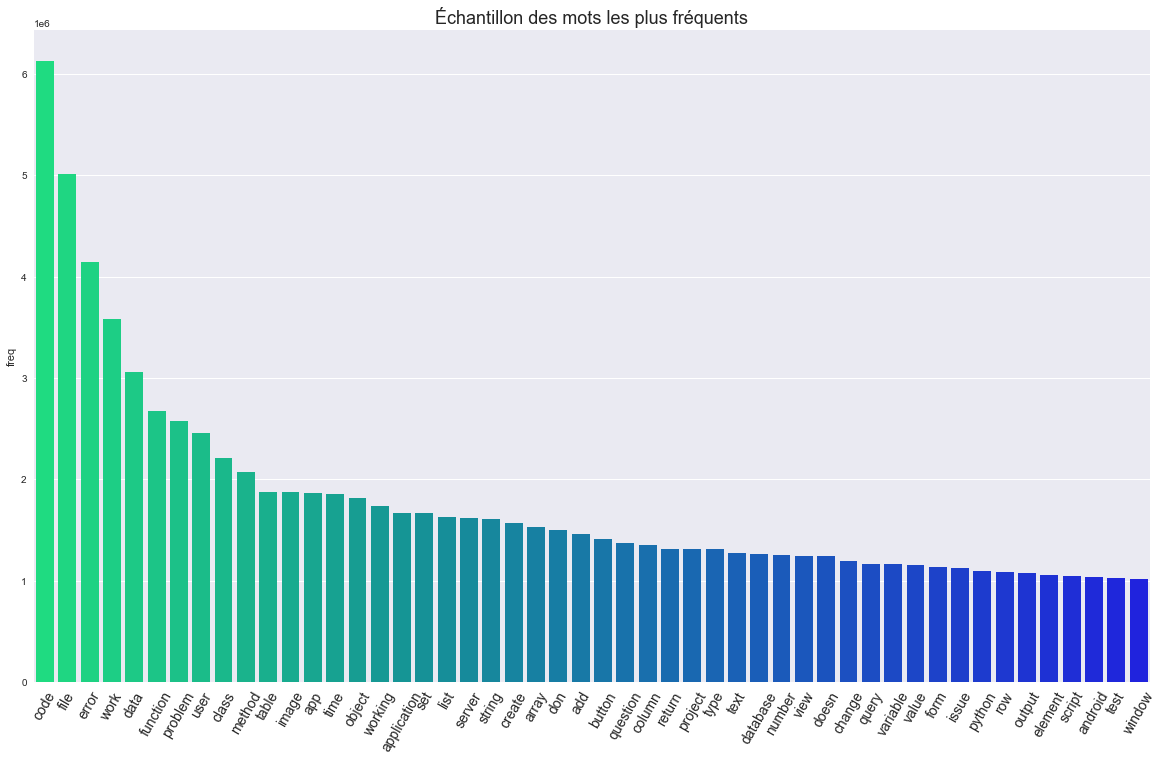

In [37]:
plt.figure(figsize=(20, 12))
plt.title("Échantillon des mots les plus fréquents", fontsize=18)
sns.barplot(x=word_sum.index[:50], y=word_sum[:50], palette='winter_r')
plt.xticks(fontsize=14, rotation=60)
plt.show()

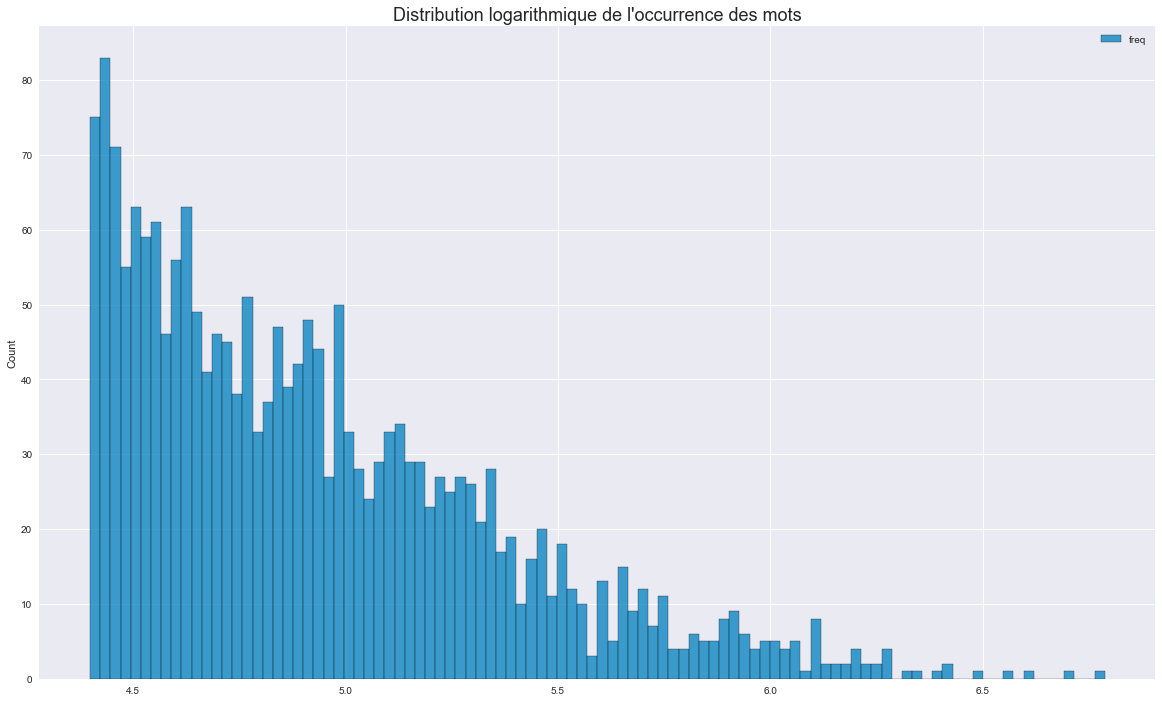

In [40]:
plt.figure(figsize=(20, 12))
sns.histplot(word_sum_log, bins=100, palette='winter_r')
plt.title("Distribution logarithmique de l'occurrence des mots", fontsize=18)
plt.show()

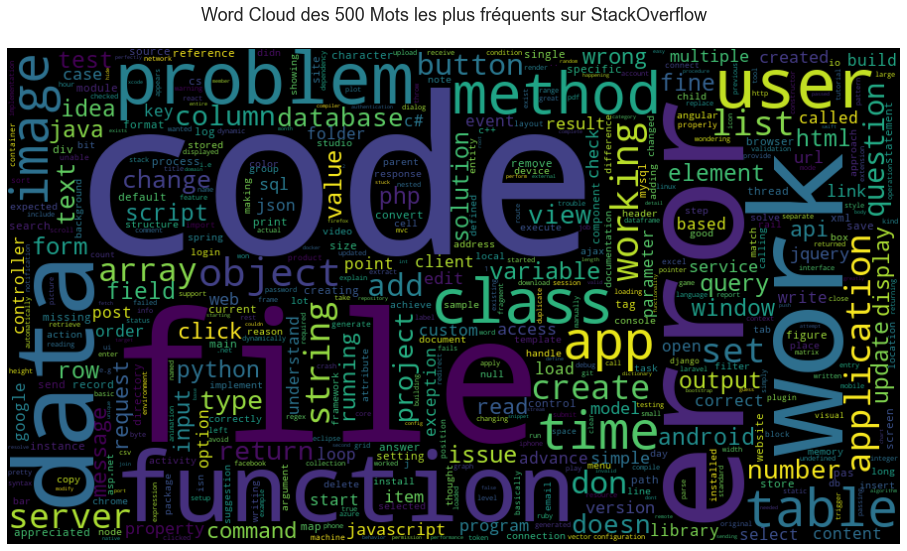

In [36]:
fig = plt.figure(1, figsize=(16, 12))
ax = fig.add_subplot(1, 1, 1)
wordcloud = WordCloud(width=900, height=500,
                      background_color="black",
                      max_words=500,
                      relative_scaling=1,
                      normalize_plurals=False)\
    .generate_from_frequencies(word_sum.to_dict())

ax.imshow(wordcloud, interpolation='bilinear')
ax.axis("off")
plt.title("Word Cloud des 500 Mots les plus fréquents sur StackOverflow\n",
          fontsize=18)
plt.show()

### Export

In [34]:
posts[["Text", "Tags_list"]].to_csv("Data/Posts_Clean_Full.csv")